seq only with attention

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [4]:
import tensorflow as tf

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                shape=(input_shape[-1], 1),
                                initializer='random_normal',
                                trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                shape=(input_shape[1], 1),
                                initializer='zeros',
                                trainable=True)
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        # inputs shape: (batch_size, time_steps, features)
        e = tf.keras.backend.tanh(tf.keras.backend.dot(inputs, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = inputs * a
        return tf.keras.backend.sum(output, axis=1)

def create_sequence_model():
    """Create CNN model with attention for sequence data"""
    input_layer = tf.keras.layers.Input(shape=(33,))
    
    # Embedding layer
    x = tf.keras.layers.Embedding(21, 21, input_length=33)(input_layer)
    x = tf.keras.layers.Reshape((33, 21, 1))(x)
    
    # Convolutional layer
    x = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), 
                              activation='relu', padding='valid')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Reshape for attention
    # Calculate the correct shape after Conv2D and MaxPooling2D
    # Original: (33, 21) -> Conv2D(17,3) -> (17, 19, 32) -> MaxPool(2,2) -> (8, 9, 32)
    x = tf.keras.layers.Reshape((-1, 32))(x)  # Flatten the spatial dimensions
    
    # Add attention layer
    x = AttentionLayer()(x)
    
    # Dense layers
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [5]:
def train_and_evaluate():
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/processed_data_train.csv")
    test_df = pd.read_csv("../data/processed_data_test.csv")
    
    # Print class distribution
    print("Class Distribution:")
    print(train_df['label'].value_counts())
    
    # Print train and test set sizes
    print(f"Train set size: {len(train_df)}")
    print(f"Test set size: {len(test_df)}")
    
    # Shuffle the training data
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Prepare sequence data
    print("Preparing sequence data...")
    X_train_seq = prepare_sequence_data(train_df)
    X_test_seq = prepare_sequence_data(test_df)
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    print(f"\nTraining data shape: {X_train_seq.shape}")
    print(f"Test data shape: {X_test_seq.shape}")
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    print("\nClass weights:", class_weights)
    
    # Initialize cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize metrics storage
    metrics = {'acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        # Create callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
        
        # Create and compile model
        model = create_sequence_model()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        print("Training model...")
        history = model.fit(
            X_train_seq[train_idx], y_train[train_idx],
            batch_size=32,
            epochs=50,
            validation_data=(X_train_seq[val_idx], y_train[val_idx]),
            callbacks=[early_stopping],
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        # plt.savefig(f'accuracy_fold_{fold}.png')
        # plt.close()
        
        # Evaluate on validation set
        y_pred = model.predict(X_train_seq[val_idx])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))
        
        # Predict on test set
        test_pred = model.predict(X_test_seq)
        test_predictions.append(test_pred)
        
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model

Loading data...
Class Distribution:
label
1    4591
0    4259
Name: count, dtype: int64
Train set size: 8850
Test set size: 2737
Preparing sequence data...

Training data shape: (8850, 33)
Test data shape: (2737, 33)

Class weights: {0: 1.0389762855130311, 1: 0.9638423001524722}

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-03 19:25:32.038475: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-03 19:25:32.038503: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-03 19:25:32.038508: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-03 19:25:32.038677: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-03 19:25:32.038690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Training model...
Epoch 1/50


2024-12-03 19:25:32.687759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5204 - loss: 0.6924 - val_accuracy: 0.5949 - val_loss: 0.6792
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5754 - loss: 0.6764 - val_accuracy: 0.6017 - val_loss: 0.6716
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5880 - loss: 0.6707 - val_accuracy: 0.5966 - val_loss: 0.6700
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6008 - loss: 0.6666 - val_accuracy: 0.5955 - val_loss: 0.6682
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6111 - loss: 0.6616 - val_accuracy: 0.6203 - val_loss: 0.6517
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6551 - loss: 0.6268 - val_accuracy: 0.6718 - val_loss: 0.6027
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6898 - loss: 0.5863 - val_accuracy: 0.6944 - val_loss: 0.5889
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7026 - loss: 0.5714 - val_accuracy: 0.698

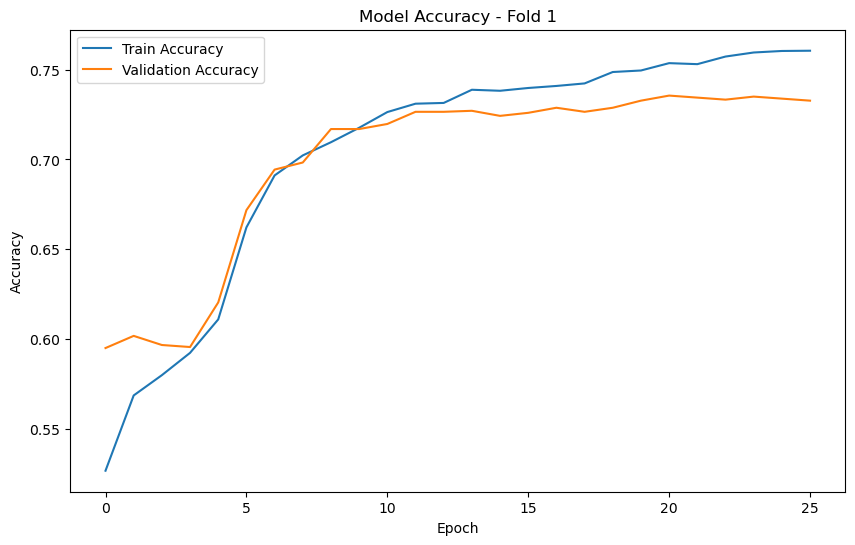

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 1 Results:
Accuracy: 0.7356
MCC: 0.4645
Sensitivity: 0.8050
Specificity: 0.6526

Fold 2/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5158 - loss: 0.6927 - val_accuracy: 0.5678 - val_loss: 0.6801
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5791 - loss: 0.6760 - val_accuracy: 0.5847 - val_loss: 0.6745
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5950 - loss: 0.6677 - val_accuracy: 0.5876 - val_loss: 0.6711
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6060 - loss: 0.6613 - val_accuracy: 0.6254 - val_loss: 0.6517
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6651 - loss: 0.6263 - val_accuracy: 0.6802 - val_loss: 0.6025
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6919 - loss: 0.5907 - val_accuracy: 0.6966 - val_loss: 0.5875
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7021 - loss: 0.5742 - val_accuracy: 0.7085 - val_loss: 0.5774
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7173 - loss: 0.5654 - val_accuracy: 0.714

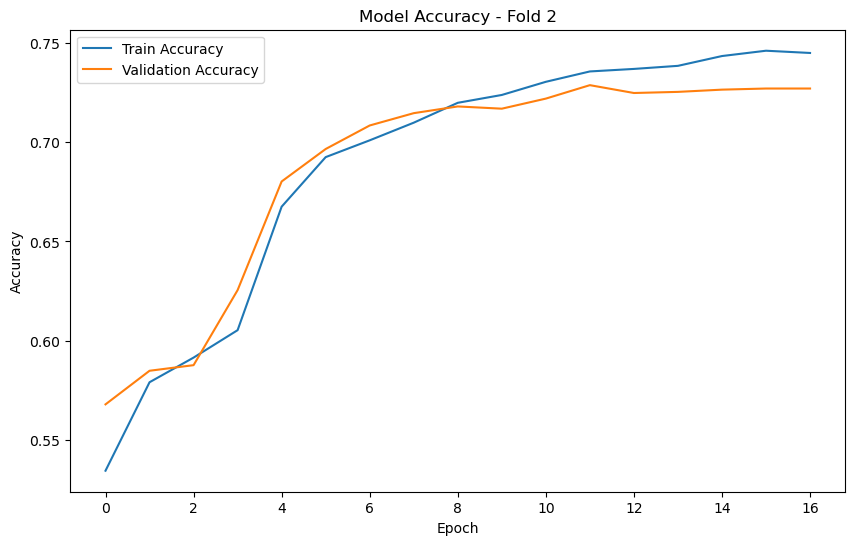

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 2 Results:
Accuracy: 0.7288
MCC: 0.4599
Sensitivity: 0.8500
Specificity: 0.5916

Fold 3/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5028 - loss: 0.6928 - val_accuracy: 0.5740 - val_loss: 0.6809
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5725 - loss: 0.6789 - val_accuracy: 0.5746 - val_loss: 0.6748
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5806 - loss: 0.6749 - val_accuracy: 0.5797 - val_loss: 0.6725
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5879 - loss: 0.6730 - val_accuracy: 0.5802 - val_loss: 0.6704
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5919 - loss: 0.6688 - val_accuracy: 0.5972 - val_loss: 0.6651
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6055 - loss: 0.6583 - val_accuracy: 0.6723 - val_loss: 0.6203
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6707 - loss: 0.6057 - val_accuracy: 0.6831 - val_loss: 0.6019
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6897 - loss: 0.5851 - val_accuracy: 0.691

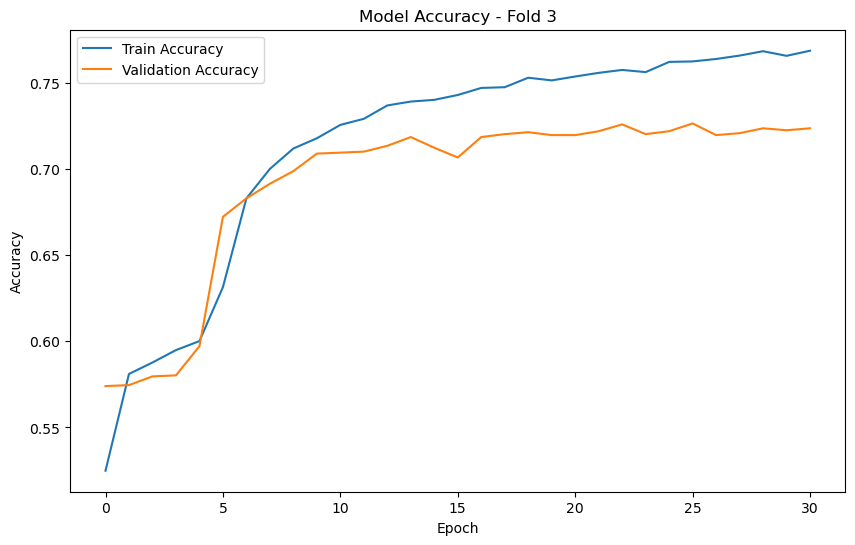

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7266
MCC: 0.4603
Sensitivity: 0.8219
Specificity: 0.6294

Fold 4/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5068 - loss: 0.6924 - val_accuracy: 0.5887 - val_loss: 0.6755
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6342 - loss: 0.6478 - val_accuracy: 0.6819 - val_loss: 0.6026
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6766 - loss: 0.6025 - val_accuracy: 0.6915 - val_loss: 0.5912
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6859 - loss: 0.5888 - val_accuracy: 0.6972 - val_loss: 0.5853
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6914 - loss: 0.5824 - val_accuracy: 0.7079 - val_loss: 0.5784
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6960 - loss: 0.5732 - val_accuracy: 0.7107 - val_loss: 0.5705
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7032 - loss: 0.5680 - val_accuracy: 0.7136 - val_loss: 0.5654
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7135 - loss: 0.5580 - val_accuracy: 0.716

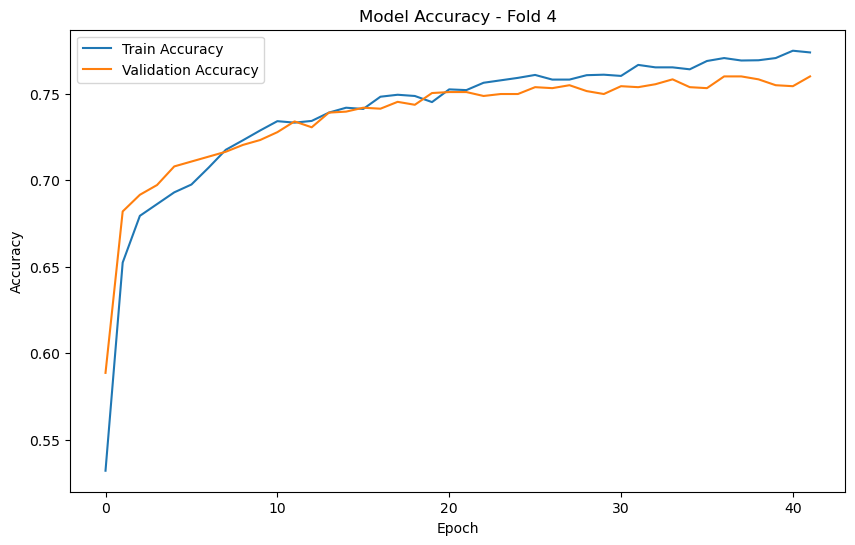

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 4 Results:
Accuracy: 0.7599
MCC: 0.5245
Sensitivity: 0.8225
Specificity: 0.6981

Fold 5/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5210 - loss: 0.6929 - val_accuracy: 0.5859 - val_loss: 0.6852
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5688 - loss: 0.6825 - val_accuracy: 0.5859 - val_loss: 0.6736
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5842 - loss: 0.6734 - val_accuracy: 0.5797 - val_loss: 0.6717
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5900 - loss: 0.6715 - val_accuracy: 0.5915 - val_loss: 0.6657
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6130 - loss: 0.6525 - val_accuracy: 0.6503 - val_loss: 0.6236
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6657 - loss: 0.6159 - val_accuracy: 0.6893 - val_loss: 0.5995
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6903 - loss: 0.5934 - val_accuracy: 0.6944 - val_loss: 0.5924
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6987 - loss: 0.5823 - val_accuracy: 0.692

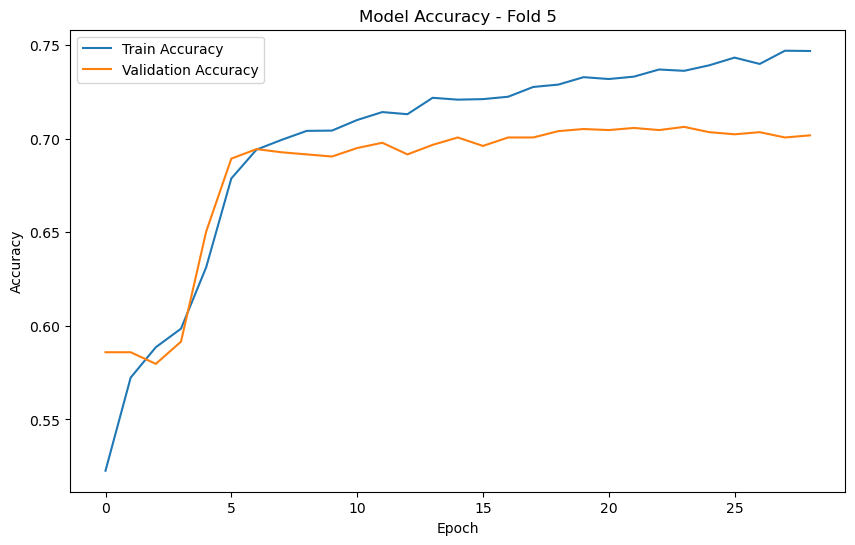

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 5 Results:
Accuracy: 0.7062
MCC: 0.4168
Sensitivity: 0.8164
Specificity: 0.5883

Average Cross-validation Results:
ACC: 0.7314 ± 0.0173
MCC: 0.4652 ± 0.0344
SN: 0.8232 ± 0.0148
SP: 0.6320 ± 0.0409

Final Test Set Results:
Accuracy: 0.6317
MCC: 0.2465
Sensitivity: 0.8167
Specificity: 0.6139
Confusion Matrix:
[[1533  964]
 [  44  196]]


In [6]:
if __name__ == "__main__":
    model = train_and_evaluate()